In [12]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
# import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
peak_hours_path = "2022-peak-hours-ca - 2022 Peak Hour Report.csv"
traffic_volumes_path = "2022 AADT DATA - 2022 AADT DATA.csv"

peak_hours_df = pd.read_csv(peak_hours_path)
traffic_volumes_df = pd.read_csv(traffic_volumes_path)

peak_hours_df.rename(columns={"RTE": "ROUTE", "CO": "COUNTY"}, inplace=True)

""" merging the dataframes """

# merged_df = pd.merge(
#     traffic_volumes_df,
#     peak_hours_df,
#     on=["ROUTE", "COUNTY", "PM"],
#     how="inner"
# )

# print(f"Merged {len(merged_df)} rows from Caltrans data.")

Merged 1084 rows from Caltrans data.


In [30]:
print(merged_df.columns)

merged_df[["AM_DAY","PM_DAY","DISTRICT","ROUTE","COUNTY"]]

Index(['DISTRICT', 'ROUTE', 'ROUTE_SFX', 'COUNTY', 'PM_PFX_x', 'PM',
       'PM_SFX_x', 'LOCATION DESCRIPTION', 'BACK_PEAK_HOUR', 'BACK_PEAK_MADT',
       'BACK_AADT', 'AHEAD_PEAK_HOUR', 'AHEAD_PEAK_MADT', 'AHEAD_AADT', 'DI',
       'RTE_SFX', 'PM_PFX_y', 'PM_SFX_y', 'CS', 'LEG', 'YR', 'AM_DIR',
       'AM_WAY_PHV', 'AM_K_FACTOR_AMT', 'AM_D_FACTOR_AMT', 'AM_KD_FACTOR',
       'AM_HOUR', 'AM_DAY', 'AM_MONTH', 'PM_DIR', 'PM_WAY_PHV',
       'PM_K_FACTOR_AMT', 'PM_D_FACTOR_AMT', 'PM_KD_FACTOR', 'PM_HOUR',
       'PM_DAY', 'PM_MONTH'],
      dtype='object')


,AM_DAY,PM_DAY,DISTRICT,ROUTE,COUNTY
0,TUE,THU,5,1,SB
1,THU,THU,5,1,SB
2,SAT,FRI,5,1,SB
3,TUE,THU,5,1,SB
4,MON,WED,5,1,SB
...,...,...,...,...,...
1079,TUE,TUE,11,805,SD
1080,TUE,THU,11,805,SD
1081,SAT,SAT,4,880,ALA
1082,WED,FRI,11,905,SD


important columns are 
- ROUTE
- COUNTY
- DAY : day of the week
- PHV : peak hour volume
- AM_DIR : direction of travel for peak volume in morning
- PM_DIR : direction of travel for peak volume in at night
- AADT : annual average daily traffic in vehicles per day

- 
- PM_HOUR : post-mile hour


In [14]:
merged_df[["BACK_PEAK_HOUR","AHEAD_PEAK_HOUR", "PM_HOUR","AM_HOUR"]]  # usually the opposite or also the same

,BACK_PEAK_HOUR,AHEAD_PEAK_HOUR,PM_HOUR,AM_HOUR
0,NaN,860.0,16,6
1,900.0,1400.0,17,6
2,1700.0,1000.0,15,12
3,2700.0,2700.0,17,7
4,2700.0,2000.0,17,7
...,...,...,...,...
1079,14500.0,14200.0,14,6
1080,9600.0,NaN,16,8
1081,13500.0,14600.0,13,10
1082,870.0,2950.0,15,7


In [15]:
# merged_df.head()
# merged_df.columns

In [16]:
direction_map = {'N': 0, 'S': 1, 'E': 2, 'W': 3}

def encode_direction(direction):
    return direction_map.get(direction, -1)  # Use -1 for unknowns or NaNs


In [17]:
examples = []
for _, row in merged_df.iterrows():
    
    am_direction = row.get("AM_DIR")
    pm_direction = row.get("PM_DIR")
    back_aadt = row.get("BACK_AADT", np.nan)
    ahead_aadt = row.get("AHEAD_AADT", np.nan)
    back_peak_hour = row.get("BACK_PEAK_HOUR", np.nan)
    ahead_peak_hour = row.get("AHEAD_PEAK_HOUR", np.nan)
    am_hour = row.get("AM_HOUR", np.nan)
    pm_hour = row.get("PM_HOUR", np.nan)
    
    # Skip rows with missing critical data
    if np.isnan(back_aadt) or np.isnan(ahead_aadt) or np.isnan(back_peak_hour) or np.isnan(ahead_peak_hour):
        continue

    for hour in range(24):
        examples.append({
            "AM_HOUR": int(am_hour),
            "PM_HOUR": int(pm_hour),
            "AM_DIRECTION": encode_direction(am_direction),
            "PM_DIRECTION": encode_direction(pm_direction),
            "BACK_PEAK_HOUR": int(back_peak_hour) if not np.isnan(back_peak_hour) else 17,
            "AHEAD_PEAK_HOUR": int(ahead_peak_hour) if not np.isnan(ahead_peak_hour) else 17,
            "BACK_AADT": back_aadt,
            "AHEAD_AADT": ahead_aadt
        })

print(f"Generated {len(examples)} simulation examples.")

def calculate_multiplier(back_peak_hour, ahead_peak_hour, back_aadt, ahead_aadt, am_dir=None, pm_dir=None):
    base_multiplier = 1.0

    # Peak Hour Boost
    if abs(pm_hour - back_peak_hour) <= 1 or abs(pm_hour - ahead_peak_hour) <= 1:
        base_multiplier += 0.6

    # --- Morning congestion boost
    if 7 <= am_hour <= 9:
        base_multiplier += 0.3

    # Nighttime reduction
    if (pm_hour >= 23 or pm_hour <= 5):
        base_multiplier -= 0.3

    # Midday moderate boost
    if 11 <= pm_hour <= 13:
        base_multiplier += 0.2

    # AADT scaling
    avg_aadt = (back_aadt + ahead_aadt) / 2
    base_multiplier += avg_aadt / 400000

    # Directional preference (example: boost if AM and PM directions match)
    if am_dir == pm_dir:
        base_multiplier += 0.1

    # Add small noise
    return max(base_multiplier + np.random.normal(0, 0.05), 1.0)


X = []
y = []

for example in examples:
    features = [
        # example["AM_HOUR"],
        # example["PM_HOUR"],
        example["AM_DIRECTION"],
        example["PM_DIRECTION"],
        example["BACK_PEAK_HOUR"],
        example["AHEAD_PEAK_HOUR"],
        example["BACK_AADT"],
        example["AHEAD_AADT"]
    ]
    multiplier = calculate_multiplier(*features)
    X.append(features)
    y.append(multiplier)

X = np.array(X)
y = np.array(y)

Generated 21768 simulation examples.


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
# model = SVR(kernel="linear", C=100, epsilon=0.1)

model.fit(X, y)

y_pred = model.predict(X_test)

In [19]:
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print results
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

R² Score: 0.2349
MAE: 0.0409
MSE: 0.0026
RMSE: 0.0506


## Understanding our Data

In [20]:
print(X_train[:5])  # First 5 rows of the feature matrix
print(y_train[:5])  # First 5 target values

# ["AM_DIRECTION","PM_DIRECTION","PM_HOUR","BACK_PEAK_HOUR","AHEAD_PEAK_HOUR","BACK_AADT","AHEAD_AADT"]

# [
#   AM_HOUR,           # 12, 12am
#   PM_HOUR,           # 13, 1pm
#   AM_DIRECTION,      # 3 → e.g., "W" if you used {'N':0, 'S':1, 'E':2, 'W':3}
#   PM_DIRECTION,      # 3 → same as above
#   PM_HOUR,           # 13 → 1 PM
#   BACK_PEAK_HOUR,    # 2600 → likely a mistake: should be an hour (0-23)
#   AHEAD_PEAK_HOUR,   # 1850 → also possibly invalid as a peak hour
#   BACK_AADT,         # 19400 → realistic
#   AHEAD_AADT         # 14100 → realistic
# ]

[[3.00e+00 3.00e+00 2.60e+03 1.85e+03 1.94e+04 1.41e+04]
 [2.00e+00 2.00e+00 2.55e+03 2.05e+03 2.29e+04 1.84e+04]
 [2.00e+00 2.00e+00 9.20e+02 8.90e+02 9.30e+03 8.50e+03]
 [1.00e+00 1.00e+00 3.35e+03 5.70e+03 3.50e+04 5.90e+04]
 [2.00e+00 2.00e+00 1.88e+04 2.18e+04 2.01e+05 1.86e+05]]
[1.47627326 1.56715985 1.52206514 1.49342089 1.59590451]


In [21]:
np.mean(y_test)

np.float64(1.5185591870694581)

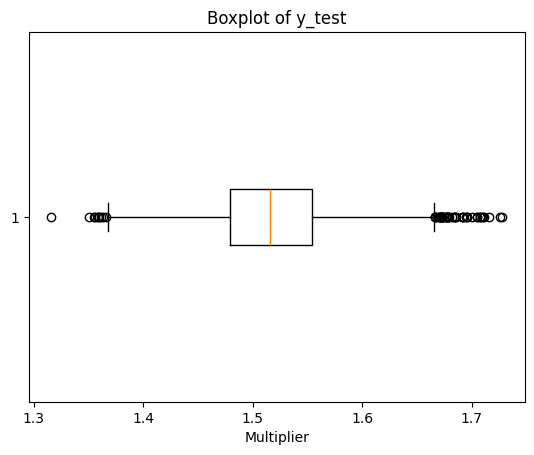

In [22]:
import matplotlib.pyplot as plt

plt.boxplot(y_test, vert=False)
plt.title("Boxplot of y_test")
plt.xlabel("Multiplier")
plt.show()


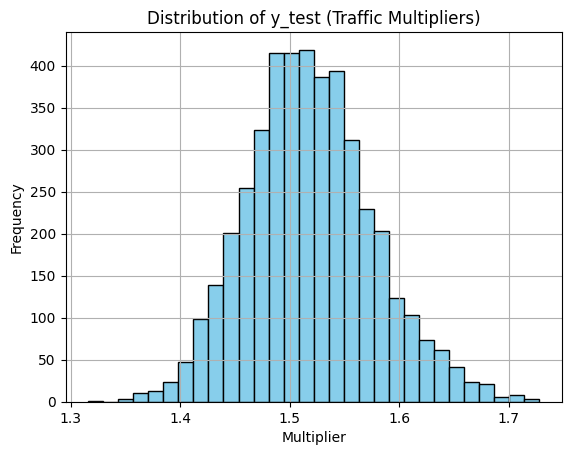

In [23]:
import matplotlib.pyplot as plt

plt.hist(y_test, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of y_test (Traffic Multipliers)")
plt.xlabel("Multiplier")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [24]:
def interpret_prediction(model_input, prediction):
    direction_map = {0: 'North', 1: 'South', 2: 'East', 3: 'West'}
    
    am_dir_code, pm_dir_code, back_peak, ahead_peak, back_aadt, ahead_aadt = model_input[0]
    
    am_direction = direction_map.get(am_dir_code, 'Unknown')
    pm_direction = direction_map.get(pm_dir_code, 'Unknown')
    
    summary = (
        f"At heading {pm_direction}, "
        f"traffic is expected to be {prediction[0]:.2f}× heavier than normal.\n"
        f"This is due to:\n"
        f"- Morning conditions: heading {am_direction}\n"
        f"- Nearby peak hours: BACK at {back_peak}:00, AHEAD at {ahead_peak}:00\n"
        f"- Traffic volumes: BACK AADT = {back_aadt}, AHEAD AADT = {ahead_aadt}"
    )
    return summary

In [25]:
model_test = [[8, 13, 7, 16, 19400, 14100]]
test = model.predict(model_test)
print(interpret_prediction(model_test, test))

At heading Unknown, traffic is expected to be 1.52× heavier than normal.
This is due to:
- Morning conditions: heading Unknown
- Nearby peak hours: BACK at 7:00, AHEAD at 16:00
- Traffic volumes: BACK AADT = 19400, AHEAD AADT = 14100
